<h1>CSE 574 - Introduction to Machine Learning</h1>
<hr>

<blockquote><h2><i>Face Detection and Classification of Facial Expressions using Convolutional Neural Networks in TensorFlow</i></h2></blockquote>

<h3>MILESTONE III</h3><br>

<h3>4th May 2020<h3>

<font color = blue><h2>Group Members:</h2><br></font>
<b>
> Kriti Asrani – 50325502 – kritiasr@buffalo.edu<br>
> Deeksha Gupta – 50320917 - deekshag@buffalo.edu<br>
> Kashyap Balasubramanian – 50325440 – kashyapb@buffalo.edu<br>
</b>

<h2>HEY THERE!<h2>
<h3>HERE, WE ARE IMPLEMENTING AN ALGORITHM TO DETECT FACES IN AN IMAGE CLICKED BY USING YOUR SYSTEM'S WEBCAM</h3>

<font color = blue><h3>We started by importing the required libraries. As we mentioned in our previous reports, we have used OpenCV for face detection and Tensorflow for emotion classification.</h3></font>

In [1]:
import os
import cv2
import PIL.Image
import PIL.ImageTk
import numpy as np
import pandas as pd
from tkinter import *
from PIL import Image
import tensorflow as tf
from ipywidgets import *
import ipywidgets as widgets
from tkinter import messagebox
from tkinter import filedialog 
import matplotlib.pyplot as plt
from keras.utils import np_utils
from IPython.display import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

categories = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happy', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

Using TensorFlow backend.


<font color = green>
    <h3>
        Here, we are splitting the dataset - FER2013.csv into 3 parts : TRAIN, VALIDATION AND TEST DATA.<br>
    </h3>
    <h4>
        Original data dimension : 35887x3<br>
        After splitting, dimension of train data : 28709x3<br>
        dimension of test data : 3589x3<br>
        dimension of validation data : 3589x3<br>
    </h4>
</font>

In [2]:
def load_split_data(path):
    data = pd.read_csv(path)
    dim_data = data.shape
    train_data = (data.loc[data['Usage'] == "Training"]).to_numpy()
    validation_data = (data.loc[data['Usage'] == "PublicTest"]).to_numpy()
    test_data = (data.loc[data['Usage'] == "PrivateTest"]).to_numpy()
    return [train_data, validation_data, test_data]

<font color = blue>
<h2>
    PRE-PROCESSING DATA
</h2>
</font>

In [3]:
def pre_processing(train_data, validate_data, test_data):
    rows_zero = len((np.where(train_data[:, 0] == 0))[0])
    rows_one = len((np.where(train_data[:, 0] == 1))[0])
    rows_two = len((np.where(train_data[:, 0] == 2))[0])
    rows_three = len((np.where(train_data[:, 0] == 3))[0])
    rows_four = len((np.where(train_data[:, 0] == 4))[0])
    rows_five = len((np.where(train_data[:, 0] == 5))[0])
    rows_six = len((np.where(train_data[:, 0] == 6))[0])
    zero = np.full(rows_zero, 0)
    one = np.full(rows_one, 1)
    two = np.full(rows_two, 2)
    three = np.full(rows_three, 3)
    four = np.full(rows_four, 4)
    five = np.full(rows_five, 5)
    six = np.full(rows_six, 6)
    args = (zero, one, two, three, four, five, six)
    join = np.concatenate(args)
    plt.hist(join, bins=(0, 1, 2, 3, 4, 5, 6, 7), color='#0504aa', alpha=0.7, rwidth=0.85)
    plt.xlabel('Expressions')
    plt.ylabel('Number of Training Samples')
    plt.title(r'Histogram of Training Data Distribution')
    plt.text(0.2, 4200, r'$Angry$')
    plt.text(1.1, 700, r'$Disgust$')
    plt.text(2.2, 4300, r'$Fear$')
    plt.text(3.2, 7300, r'$Happy$')
    plt.text(4.2, 4900, r'$Sad$')
    plt.text(5.1, 3300, r'$Surprise$')
    plt.text(6.2, 5100, r'$Neutral$')
    plt.show()
    indices = np.random.choice(np.where(train_data[:, 0] == 1)[0], size=4000, replace=True)
    f = train_data[indices]
    train_data = np.vstack((train_data, f))
    indices = np.random.choice(np.where(train_data[:, 0] == 3)[0], size=4000, replace=True)
    train_data = np.delete(train_data, indices, axis=0)
    train_x = []
    for i in range(0, train_data.shape[0]):
        list_image = train_data[i, 1].split(" ")
        list_image = list(map(int, list_image))
        pix_array = np.array(list_image).reshape(48, 48)
        train_x.append(pix_array)
    train_x = np.asarray(train_x)
    train_y = train_data[:, 0].astype(str)
    validate_x = []
    for i in range(0, validate_data.shape[0]):
        list_image = validate_data[i, 1].split(" ")
        list_image = list(map(int, list_image))
        pix_array = np.array(list_image).reshape(48, 48)
        validate_x.append(pix_array)
    validate_x = np.asarray(validate_x)
    validate_y = validate_data[:, 0].astype(str)
    test_x = []
    for i in range(0, test_data.shape[0]):
        list_image = test_data[i, 1].split(" ")
        list_image = list(map(int, list_image))
        pix_array = np.array(list_image).reshape(48, 48)
        test_x.append(pix_array)
    test_x = np.asarray(test_x)
    test_y = test_data[:, 0].astype(str)
    return [train_x, train_y, validate_x, validate_y, test_x, test_y]

<h3><font color = red>PRE-PROCESSING STEPS :<br></font></h3>
<blockquote>
<h3>
    <font color = green>
        1. Checked for missing data.<br>
        2. Couting number of rows for each expression.<br>
        3. Checked the data distribution by plotting a histogram.<br>
        4. Performed random 'Under-sampling' for Happy images.<br>
        5. Performed random 'Over-sampling' for Disgust images.<br>
        6. Changed Pixel Data to 2D arrays.<br>
    </font>
</h3>
</blockquote>

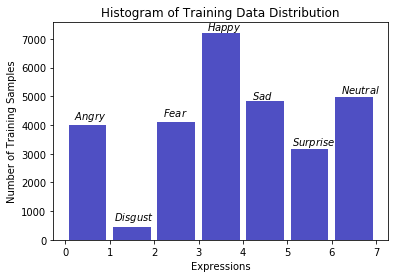

In [25]:
[train, validate, test] = load_split_data("fer2013.csv")
[train_x, train_y, validate_x, validate_y, test_x, test_y] = pre_processing(train, validate, test)
train_x = (train_x.reshape(-1, 48, 48, 1).astype('float32')) / 255
train_y = np_utils.to_categorical(train_y)
validate_x = (validate_x.reshape(-1, 48, 48, 1).astype('float32')) / 255
validate_y = np_utils.to_categorical(validate_y)
test_x = (test_x.reshape(-1, 48, 48, 1).astype('float32')) / 255
test_y = np_utils.to_categorical(test_y)

<h3>We trained the CNN model and we got 92.28% training accuracy and 54.17% Validation Accuracy</h3>

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 42, 42, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 9, 9, 64)         

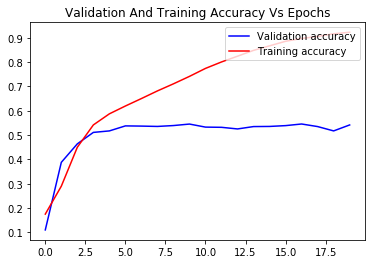

<Figure size 432x288 with 0 Axes>

In [42]:
def train_model(train_x, train_y, validate_x, validate_y):
    classes = 7
    cnn_model = Sequential()
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), data_format="channels_last"))
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2), padding='same', strides=2))
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), data_format="channels_last"))
    cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    cnn_model.add(MaxPooling2D((2, 2), padding='same', strides=2))
    cnn_model.add(MaxPooling2D((2, 2), padding='same', strides=2))
    cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.3))
    cnn_model.add(Dense(classes, activation='softmax'))
    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cnn_model.summary()
    fit_model = cnn_model.fit(train_x, train_y, epochs=20, shuffle=True, batch_size=100, validation_data=(validate_x, validate_y), verbose=2)
    cnn_model.save("cnn_modeltry.h5py")
    acc_val = fit_model.history['val_accuracy']
    acc_train = fit_model.history['accuracy']
    epochs = range(len(acc_val))
    plt.plot(epochs, acc_val, "-b", label='Validation accuracy')
    plt.plot(epochs, acc_train, "-r", label='Training accuracy')
    plt.title('Validation And Training Accuracy Vs Epochs')
    plt.legend(loc="upper right")
    plt.figure()
    plt.show()
    return fit_model
fit_model=train_model(train_x, train_y, validate_x, validate_y)

<h3>As shown below, we got test accuracy of 53.97%</h3>

In [44]:
def show_accuracy(test_x, test_y):
    new_model = tf.keras.models.load_model('cnn_modeltry.h5py')
    test_evaluated = new_model.evaluate(test_x, test_y, verbose=1)
    print('Test accuracy:', test_evaluated[1])
    new_model.summary()

show_accuracy(test_x, test_y)

3589/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [12]:
def load_model():
    new_model = tf.keras.models.load_model('cnn_modeltry.h5py')
    return new_model

<font color = blue>
<h3>
Here, we are capturing an image from the webcam. Followed by detecting the number of faces in the captured image. Next, we predicted the emotion of the face. We started by loading our model, starting the webcam, capturing and saving the image, converting it to gray-scale, identifying number of faces, classifying the face for a particular emotion by passing the image as an input to our CNN model and finally showing the detected image.</h3>
</font>

In [8]:
def detect_faces(b):
    
    new_model = load_model()
    f_classifer = cv2.CascadeClassifier('ren.xml')
    camera = cv2.VideoCapture(0)
    cv2.namedWindow("snap")
    while True:
        ret, frame = camera.read()
        cv2.imshow("snap", frame)
        if not ret:
            break
        win = cv2.waitKey(1)
        if win % 256 == 32:
            cv2.imwrite("snapshot.png", frame)
            print("Image captured!")
        elif win % 256 == 27:
            print("Closing the webcam!")
            break
    camera.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    img_col = cv2.imread('snapshot.png')
    img_gray = cv2.cvtColor(img_col, cv2.COLOR_BGR2GRAY)
    cv2.imwrite("gray.jpg", img_gray)
    face_front = f_classifer.detectMultiScale(img_gray, 1.1, 5)
    l = len(face_front)
    if l == 0:
        print("No face detected!")
    else:
        for (a, b, c, d) in face_front:
            cv2.rectangle(img_col, (a, b), (a + c, b + d), (255, 0, 0), 2)
        print("Detected {0} face(s)!".format(l))
        path_file_name = "detected.jpg"
        cv2.imwrite(path_file_name, img_col)
        pil_im = PIL.Image.open('gray.jpg')
        out = pil_im.resize((48, 48))
        img = np.asarray(out)
        path_file_name = "test_out.jpg" 
        cv2.imwrite(path_file_name, img)
        img = (img.reshape(-1, 48, 48, 1).astype('float32')) / 255
        pred = new_model.predict(img)
        pred_class = np.round(pred)
        pred_class=np.argmax(pred_class)
        for k, v in categories.items():
            if pred_class == k:
                print("And the expression is number {0} which is {1}".format(k, v))
        print("The detected image is: ")
        img = cv2.imread('detected.jpg')
        plt.imshow(img)

In [9]:
buttons = Layout(align_items = 'stretch', border = 'solid', width = '50%', height='80px')
out = widgets.Output()

click_image = Button(description = 'PRESS TO START THE WEBCAM', layout = buttons, button_style = 'success')
click_image.on_click(detect_faces)

Button(button_style='success', description='PRESS TO START THE WEBCAM', layout=Layout(align_items='stretch', b…

Output()

Image captured!
Image captured!
Image captured!
Image captured!
Image captured!
Image captured!
Image captured!
Image captured!
Image captured!
Closing the webcam!
Detected 1 face(s)!
And the expression is number 0 which is Angry
The detected image is: 


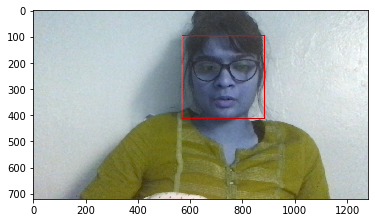

In [10]:
display(click_image, out)

<font color = Red>
<h3>
Press Spacebar to click an image through webcam and then press escape to close the webcam. 
</h3>
<h4>
Note: The webcam feature might not work properly in some versions of MacOS due to different privacy settings. 
</h4>
</font>